In [9]:
#!/usr/bin/env python
# encoding: utf-8
from __future__ import absolute_import, division, print_function, unicode_literals
# Install TensorFlow
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten , Convolution2D, MaxPooling2D , Lambda, Conv2D, Activation,Concatenate
from tensorflow.keras.layers import ActivityRegularization
from tensorflow.keras.optimizers import Adam , SGD , Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers , initializers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import NumpyArrayIterator



gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only use the first GPU
try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
except RuntimeError as e:
# Visible devices must be set before GPUs have been initialized
    print(e)



from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
# from xgboost import XGBClassifier
import tensorflow.keras.backend as K
from sklearn import metrics



# !pip3 install keras-tuner --upgrade
# !pip3 install autokeras
import kerastuner as kt
import autokeras as ak

# Import local libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import pandas as pd
import importlib
import os
from tqdm import tqdm 
import logging

importlib.reload(logging)
logging.basicConfig(level = logging.INFO)


logging.info("Tensorflow Version is {}".format(tf.__version__))
logging.info("Keras Version is {}".format(tf.keras.__version__))
from tensorflow.python.client import device_lib
logging.info(device_lib.list_local_devices())
tf.device('/device:XLA_GPU:0')
!nvidia-smi

%config InlineBackend. figure_format = 'retina'

INFO:root:Tensorflow Version is 2.4.1
INFO:root:Keras Version is 2.4.0
INFO:root:[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7848961598114735565
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1048576000
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 7148044972043756254
physical_device_desc: "device: 0, name: A100-SXM-80GB, pci bus id: 0000:4c:00.0, compute capability: 8.0"
]


1 Physical GPUs, 1 Logical GPU
Wed Nov 17 00:39:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM-80GB       On   | 00000000:4C:00.0 Off |                    0 |
| N/A   45C    P0    73W / 400W |    568MiB / 81251MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                         

# Separate Dataset

In [52]:
%%time
HOMEPATH = "/dicos_ui_home/alanchung/Universality_Boosetd_Higgs/"
JetImagePath =  HOMEPATH + "Data_ML/" +"Image_Directory/"
savepath = HOMEPATH + "Data_ML/"


    
try:
    
    data_dict ={
            "herwig_ang" : [0,0],
#             "pythia_def" : [0,0],
#             "pythia_vin" : [0,0],
#             "pythia_dip" : [0,0],
#             "sherpa_def" : [0,0],
              }  
    
    Norm_dict ={
            "herwig_ang" : [0,0],
#             "pythia_def" : [0,0],
#             "pythia_vin" : [0,0],
#             "pythia_dip" : [0,0],
#             "sherpa_def" : [0,0],
              }  
    
    data_train = {
            "herwig_ang_train" : 0,
#             "pythia_def_train" : 0,
#             "pythia_vin_train" : 0,
#             "pythia_dip_train" : 0,
#             "sherpa_def_train" : 0
            }  
    

    for i, element in enumerate(data_dict):
        data_dict[element][0] = pd.read_csv(savepath + str(element) + "_H_dict.csv")
        data_dict[element][1] = pd.read_csv(savepath + str(element) + "_QCD_dict.csv")
#         logging.info(len(data_dict[element][0]),len(data_dict[element][1]))
    
    for i, element in enumerate(Norm_dict):
        average_H = np.load(savepath + "average" + "_" + str(element) + "_H.npy")
        variance_H = np.load(savepath + "variance" + "_" + str(element) + "_H.npy")
        average_QCD = np.load(savepath + "average" + "_" + str(element) + "_QCD.npy")
        variance_QCD = np.load(savepath + "variance" + "_" + str(element) + "_QCD.npy")
        length_H = len(data_dict[element][0])
        length_QCD = len(data_dict[element][1])
        
        Norm_dict[element][0] = (average_H*length_H + average_QCD*length_QCD)/(length_H+length_QCD)
        Norm_dict[element][1] =  variance_H + variance_QCD
        
    for i,(element, dict_element) in enumerate(zip(data_train, data_dict)):
        
        """
        Pt Range Study
        """
        tmp = pd.read_csv(HOMEPATH + "Notebook/KFold_CNN/" + str(element) + ".csv")
        tmp = tmp[(tmp["PTJ_0"] >= pt_min)  & (tmp["PTJ_0"] < pt_max)]
        tmp = tmp[(tmp["MJ_0"] >= 110)  & (tmp["MJ_0"] < 160)]
        data_train[element] = shuffle(tmp)
        
        H_tmp = data_train[element][data_train[element]["target"] == 1]
        QCD_tmp = data_train[element][data_train[element]["target"] == 0]
        
        H_dict = data_dict[dict_element][0].iloc[H_tmp["index"].values]
        QCD_dict = data_dict[dict_element][1].iloc[QCD_tmp["index"].values]
        
        data_train[element] = pd.concat([H_dict, QCD_dict], ignore_index=True, axis=0,join='inner')
        data_train[element] = shuffle(data_train[element])
        


    logging.info("All Files are loaded!")

    logging.info("H jet : QCD jet = 1 : 1")
    logging.info("\r")
    train = [ len(data_train[element]) for j, element in enumerate(data_train)]
    logging.info("{:^8}{:^15}".format("",str(element)))
    logging.info("{:^8}{:^15}".format("Train #",train[0]))
    
    
    for i, element in enumerate(data_train):
        total_list = data_train[element].columns
        break
    
    logging.info("total_list {}".format(total_list))

except:
    
    logging.info("Please create training, test and validation datasets.")
    

INFO:root:All Files are loaded!
INFO:root:H jet : QCD jet = 1 : 1
INFO:root:
INFO:root:        herwig_ang_train
INFO:root:Train #     307456     
INFO:root:total_list Index(['JetImage', 'Y'], dtype='object')


CPU times: user 2.32 s, sys: 111 ms, total: 2.43 s
Wall time: 2.42 s


In [44]:
def CNN_Model(name):
    """
    Declare the Input Shape
    """
    input_shape = (3,40,40)#(1, 40,40)


    """
    Create a Sequential Model
    """
    model_CNN = Sequential(name = "Model_CNN_"+str(name))


    """
    Add a "Conv2D" Layer into the Sequential Model
    """
    model_CNN.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                     activation='relu',
                     data_format='channels_first',
    #                data_format='channels_last',
                    input_shape=input_shape, 
                    name = 'Conv2D_1'))

    """
    Add a "MaxPooling2D" Layer into the Sequential Model
    """
    model_CNN.add(MaxPooling2D(pool_size=(2, 2), 
                               strides=(2, 2),
                               data_format='channels_first', 
    #                            data_format='channels_last',
                               name = 'jet_MaxPooling_1'))

    """
    Add a "Conv2D" Layer into the Sequential Model
    """
    model_CNN.add(Conv2D(64, kernel_size=(5, 5), strides=(1, 1),
                     activation='relu',
                     data_format='channels_first',
    #                data_format='channels_last',
                    input_shape=input_shape, 
                    name = 'Conv2D_2'))

    """
    Add a "MaxPooling2D" Layer into the Sequential Model
    """
    model_CNN.add(MaxPooling2D(pool_size=(2, 2), 
                               strides=(2, 2),
                               data_format='channels_first', 
    #                            data_format='channels_last',
                               name = 'jet_MaxPooling_2'))



    """
    Flatten
    """
    model_CNN.add(Flatten(name = 'jet_flatten'))


    """
    Put Output from Flatten Layer into "Dense" Layer with 300 neurons
    """
    model_CNN.add(Dense(300, activation='relu', name = 'jet_dense_1'))
    model_CNN.add(Dense(150, activation='relu', name = 'jet_dense_2'))


    model_CNN.add(Dropout(0.01, name = 'Dropout'))


    """
    Add Output "Dense" Layer with 2 neurons into the Sequential Model
    """
    model_CNN.add(Dense(1, activation='sigmoid', name = 'output'))
    # model_CNN.add(Dense(2, activation='softmax', name = 'output'))

    """
    Declare the Optimizer
    """
    model_opt = keras.optimizers.Adadelta()
    # model_opt = keras.optimizers.Adam()


    """
    Compile Model
    """
    model_CNN.compile(
    #                     loss="categorical_crossentropy",
                       loss = "binary_crossentropy",
                       optimizer=model_opt,
                       metrics=["accuracy","mse"])

    """
    logging.info Architecture
    """
    model_CNN.summary()

    return model_CNN


In [19]:
def Loading_Data(data_source, datadict, start=0, stop=20000):
    x_jet, target = [], []

    time.sleep(0.5)
    for k in tqdm(range(start,len(data_source))):
        x_jet_path = savepath + "Image_Directory/"+ data_source["JetImage"].iloc[k]
        x_jet_tmp = np.load(x_jet_path)["jet_image"]
        if np.isnan(x_jet_tmp).any() == True:
            continue 

        target.append(data_source["Y"].iloc[k])
        x_jet_tmp = np.divide((x_jet_tmp - Norm_dict[datadict][0]), (np.sqrt(Norm_dict[datadict][1])+1e-5))#[0].reshape(1,40,40)
        x_jet.append(x_jet_tmp)


        if k == stop:
            break

    return np.asarray(x_jet), np.asarray(target)

In [48]:

"""
Define generator()
"""

# nb_train_samples = len(data_train["pythia_def_train"]) // 100
# nb_val_samples = len(data_val["pythia_def_val"]) // 10
# nb_test_samples = len(data_test["pythia_def_test"]) 


# batch_size = 512

# HOMEPATH = "/dicos_ui_home/alanchung/UniversalityCNN_DiHiggs/"
# JetImagePath =  HOMEPATH + "Data_ML/" +"Image_Directory_Leading/"

def generator(data_source, batch_size, datadict):
    while True:
        for start in range(0, len(data_source), batch_size):
            x_batch = []
            y_batch = []

            end = min(start + batch_size, len(data_source))
            for img_path in range(start, end):
                
                x_jet_path = savepath + "Image_Directory/"+ data_source["JetImage"].iloc[img_path]
                x_jet = np.load(x_jet_path)["jet_image"]
                if np.isnan(x_jet).any() == True:
                    continue 
    
                x_jet = np.divide((x_jet - Norm_dict[datadict][0]), (np.sqrt(Norm_dict[datadict][1])+1e-5))#[0].reshape(1,40,40)
                x_batch.append(x_jet)
                y_batch.append(data_source["Y"].iloc[img_path])
                
#             logging.info(len(x_batch),len(y_batch)
            yield (np.array(x_batch), np.array(y_batch))#to_categorical(np.array(y_batch)))


In [ ]:
%%time

CNN_Model_A1 = {
              "herwig_ang" : 0,
#               "pythia_def" : 0, 
#               "pythia_vin" : 0, 
#               "pythia_dip" : 0, 
#               "sherpa_def" : 0,
            }


kf = KFold(n_splits = 10)

pt_min, pt_max = 300, 500

for i, (model, trainingdata, datadict) in enumerate(zip(CNN_Model_A1, data_train, data_dict)):

    logging.info("CNN Model: {}  Training Data: {}".format(model, trainingdata))
    
    for model_index, (train_index, val_index) in enumerate(kf.split(data_train[trainingdata]["Y"])):
        training_data = data_train[trainingdata].iloc[train_index]#[:10000]
        validation_data = data_train[trainingdata].iloc[val_index]#[:10000]
        
        if model_index == 1:
            break
        
       
        try:
            CNN_Model_A1[model] = load_model("./"+str(model)+"_KFold/CNN_"+str(model)+"_Models_"+str(int(pt_min))+str(int(pt_max))+"/" + str(model) + "_CNN_"+str(model_index)+ ".h5")
            logging.info(str(model) + " CNN model 1 is loaded!")
            logging.info("######################################################################################")
            logging.info("\n")

        except:
            logging.info("Let's train a CNN model for {}".format(model))
            logging.info("######################################################################################")
            logging.info("\n")
            if os.path.exists("./"+str(model)+"_KFold/CNN_"+str(model)+"_Models_"+str(int(pt_min))+str(int(pt_max))) == 0:
                os.mkdir("./"+str(model)+"_KFold/CNN_"+str(model)+"_Models_"+str(int(pt_min))+str(int(pt_max)))
                
                
#             x_train_jet, target_train = Loading_Data(training_data, datadict, start=0, stop= len(training_data))
            x_val_jet, target_val = Loading_Data(validation_data, datadict, start=0, stop= len(validation_data))
    

            ticks_1 = time.time()

            model_CNN = CNN_Model(model+"_"+str(model_index))

            Performance_Frame = {
                            "AUC" : [0],
                            "max_sig" : [0],
                            "r05" : [0],
                            "time": [0]
                            }


            check_list=[]
            csv_logger = CSVLogger("./"+str(model)+"_KFold/CNN_"+str(model)+"_Models_"+str(int(pt_min))+str(int(pt_max))+"/" + str(model) + "_CNN_training_log_"+str(model_index)+".csv")
            checkpoint = ModelCheckpoint(
                                filepath= "./"+str(model)+"_KFold/CNN_"+str(model)+"_Models_"+str(int(pt_min))+str(int(pt_max))+"/" + str(model) + "_CNN_checkmodel_"+str(model_index)+".h5",
                                save_best_only=True,
                                verbose=0)
            
            earlystopping = EarlyStopping(
                                monitor="val_loss",
                                min_delta=0,
                                patience=20,
                                verbose=0,
                                mode="auto",
                                baseline=None,
                                restore_best_weights=False,
                            )

            check_list.append(checkpoint)
            check_list.append(csv_logger)
            check_list.append(earlystopping)
            
            
#             History = model_CNN.fit(
#                                     np.asarray(x_train_jet), np.asarray(target_train),
#                                     validation_data = (np.asarray(x_val_jet), np.asarray(target_val)),
#             #                         validation_split = 0.2,
#                                     batch_size=512,
#                                     epochs=200,
#                                     callbacks=check_list,
#                                     shuffle=True,
#                                     verbose=1
#                                     )
            batch_size = 512
            nb_train_samples = len(training_data)
            nb_val_samples = len(validation_data)
            
            History = model_CNN.fit(
                                    generator(training_data, batch_size, datadict),
                                    epochs= 200,
                                    steps_per_epoch= nb_train_samples // batch_size,
                                    validation_data= generator(validation_data, batch_size, datadict),
                                    validation_steps = nb_val_samples // batch_size,
                                    verbose=1
                                    )


            model_CNN.save("./"+str(model)+"_KFold/CNN_"+str(model)+"_Models_"+str(int(pt_min))+str(int(pt_max))+"/" + str(model) + "_CNN_"+str(model_index)+ ".h5")
            hist_df = pd.DataFrame(History.history) 
            hist_df.to_csv("./"+str(model)+"_KFold/CNN_"+str(model)+"_Models_"+str(int(pt_min))+str(int(pt_max))+"/" + str(model) + "_history_CNN_"+str(model_index)+ ".csv")

            CNN_Model_A1[model] = model_CNN
            
            prediction_test =  model_CNN.predict(np.asarray(x_val_jet))
            discriminator_test = prediction_test
            discriminator_test = discriminator_test/(max(discriminator_test))
            
            Performance_Frame["AUC"][0] = metrics.roc_auc_score(validation_data["Y"],discriminator_test)
            FalsePositiveFull, TruePositiveFull, _ = metrics.roc_curve(validation_data["Y"],discriminator_test)
            tmp = np.where(FalsePositiveFull != 0)
            Performance_Frame["max_sig"][0] = max(TruePositiveFull[tmp]/np.sqrt(FalsePositiveFull[tmp])) 
            tmp = np.where(TruePositiveFull >= 0.5)
            Performance_Frame["r05"][0]= 1./FalsePositiveFull[tmp[0][0]]
            
            Performance_Frame["time"][0] = (time.time() - ticks_1)/60.
            
            dataframe = pd.DataFrame(Performance_Frame)
            
            
            try:
                save_to_csvdata = pd.read_csv("./"+str(model)+"_KFold/CNN_"+str(model)+"_to_"+str(trainingdata)+"_Performance_Table_"+str(int(pt_min))+str(int(pt_max))+".csv")
                DATA = pd.concat([save_to_csvdata, dataframe], ignore_index=True, axis=0,join='inner')
                DATA.to_csv("./"+str(model)+"_KFold/CNN_"+str(model)+"_to_"+str(trainingdata)+"_Performance_Table_"+str(int(pt_min))+str(int(pt_max))+".csv", index = 0)
                
            except:
                dataframe.to_csv("./"+str(model)+"_KFold/CNN_"+str(model)+"_to_"+str(trainingdata)+"_Performance_Table_"+str(int(pt_min))+str(int(pt_max))+".csv", index = 0)
            
            ticks_2 = time.time()
            ############################################################################################################################################################
            totaltime =  ticks_2 - ticks_1
            logging.info("\n")
            logging.info("\033[3;33mTime consumption : {:.4f} min for CNN\033[0;m".format(totaltime/60.))
            logging.info("######################################################################################")
            logging.info("\n")
            
            


In [6]:

# logging.info(time.strftime("%a %b %d %H:%M:%S %Y", time.localtime()))
# ticks_1 = time.time()
# ################################################################################################################

# # model_CNN = CNN_Model()

# """
# Model Training
# """
# # History = model_CNN.fit(
# #             train_generator(),
# #             epochs= 50,
# #             steps_per_epoch= nb_train_samples // batch_size,
# #             validation_data= val_generator(),
# #             validation_steps = nb_val_samples // batch_size,
# #             verbose=1
# #             )
# model_CNN = load_model(savepath + "NN_Models/model_CNN_2.h5")

# History = model_CNN.fit(np.asarray(x_train_jet), np.asarray(target_train),
#                         validation_data = (np.asarray(x_val_jet), np.asarray(target_val)),
# #                         validation_split = 0.2,
#                         batch_size=512,
#                         epochs=200,
#                         shuffle=True,
#                         verbose=1
#                         )

# """
# Save Model
# """
# model_CNN.save(savepath + "NN_Models/model_CNN_2.h5")

# hist_df = pd.DataFrame(History.history) 
# hist_df.to_csv(savepath + "NN_Models/CNN_History_2.csv")

            
# #########################################################################################
# ticks_2 = time.time()
# totaltime =  ticks_2 - ticks_1
# logging.info("\n")
# logging.info("\033[3;33mTime Cost : {:.4f} min\033[0;m".format(totaltime/60.))            
# ################################################################################################################


# Learning Curves

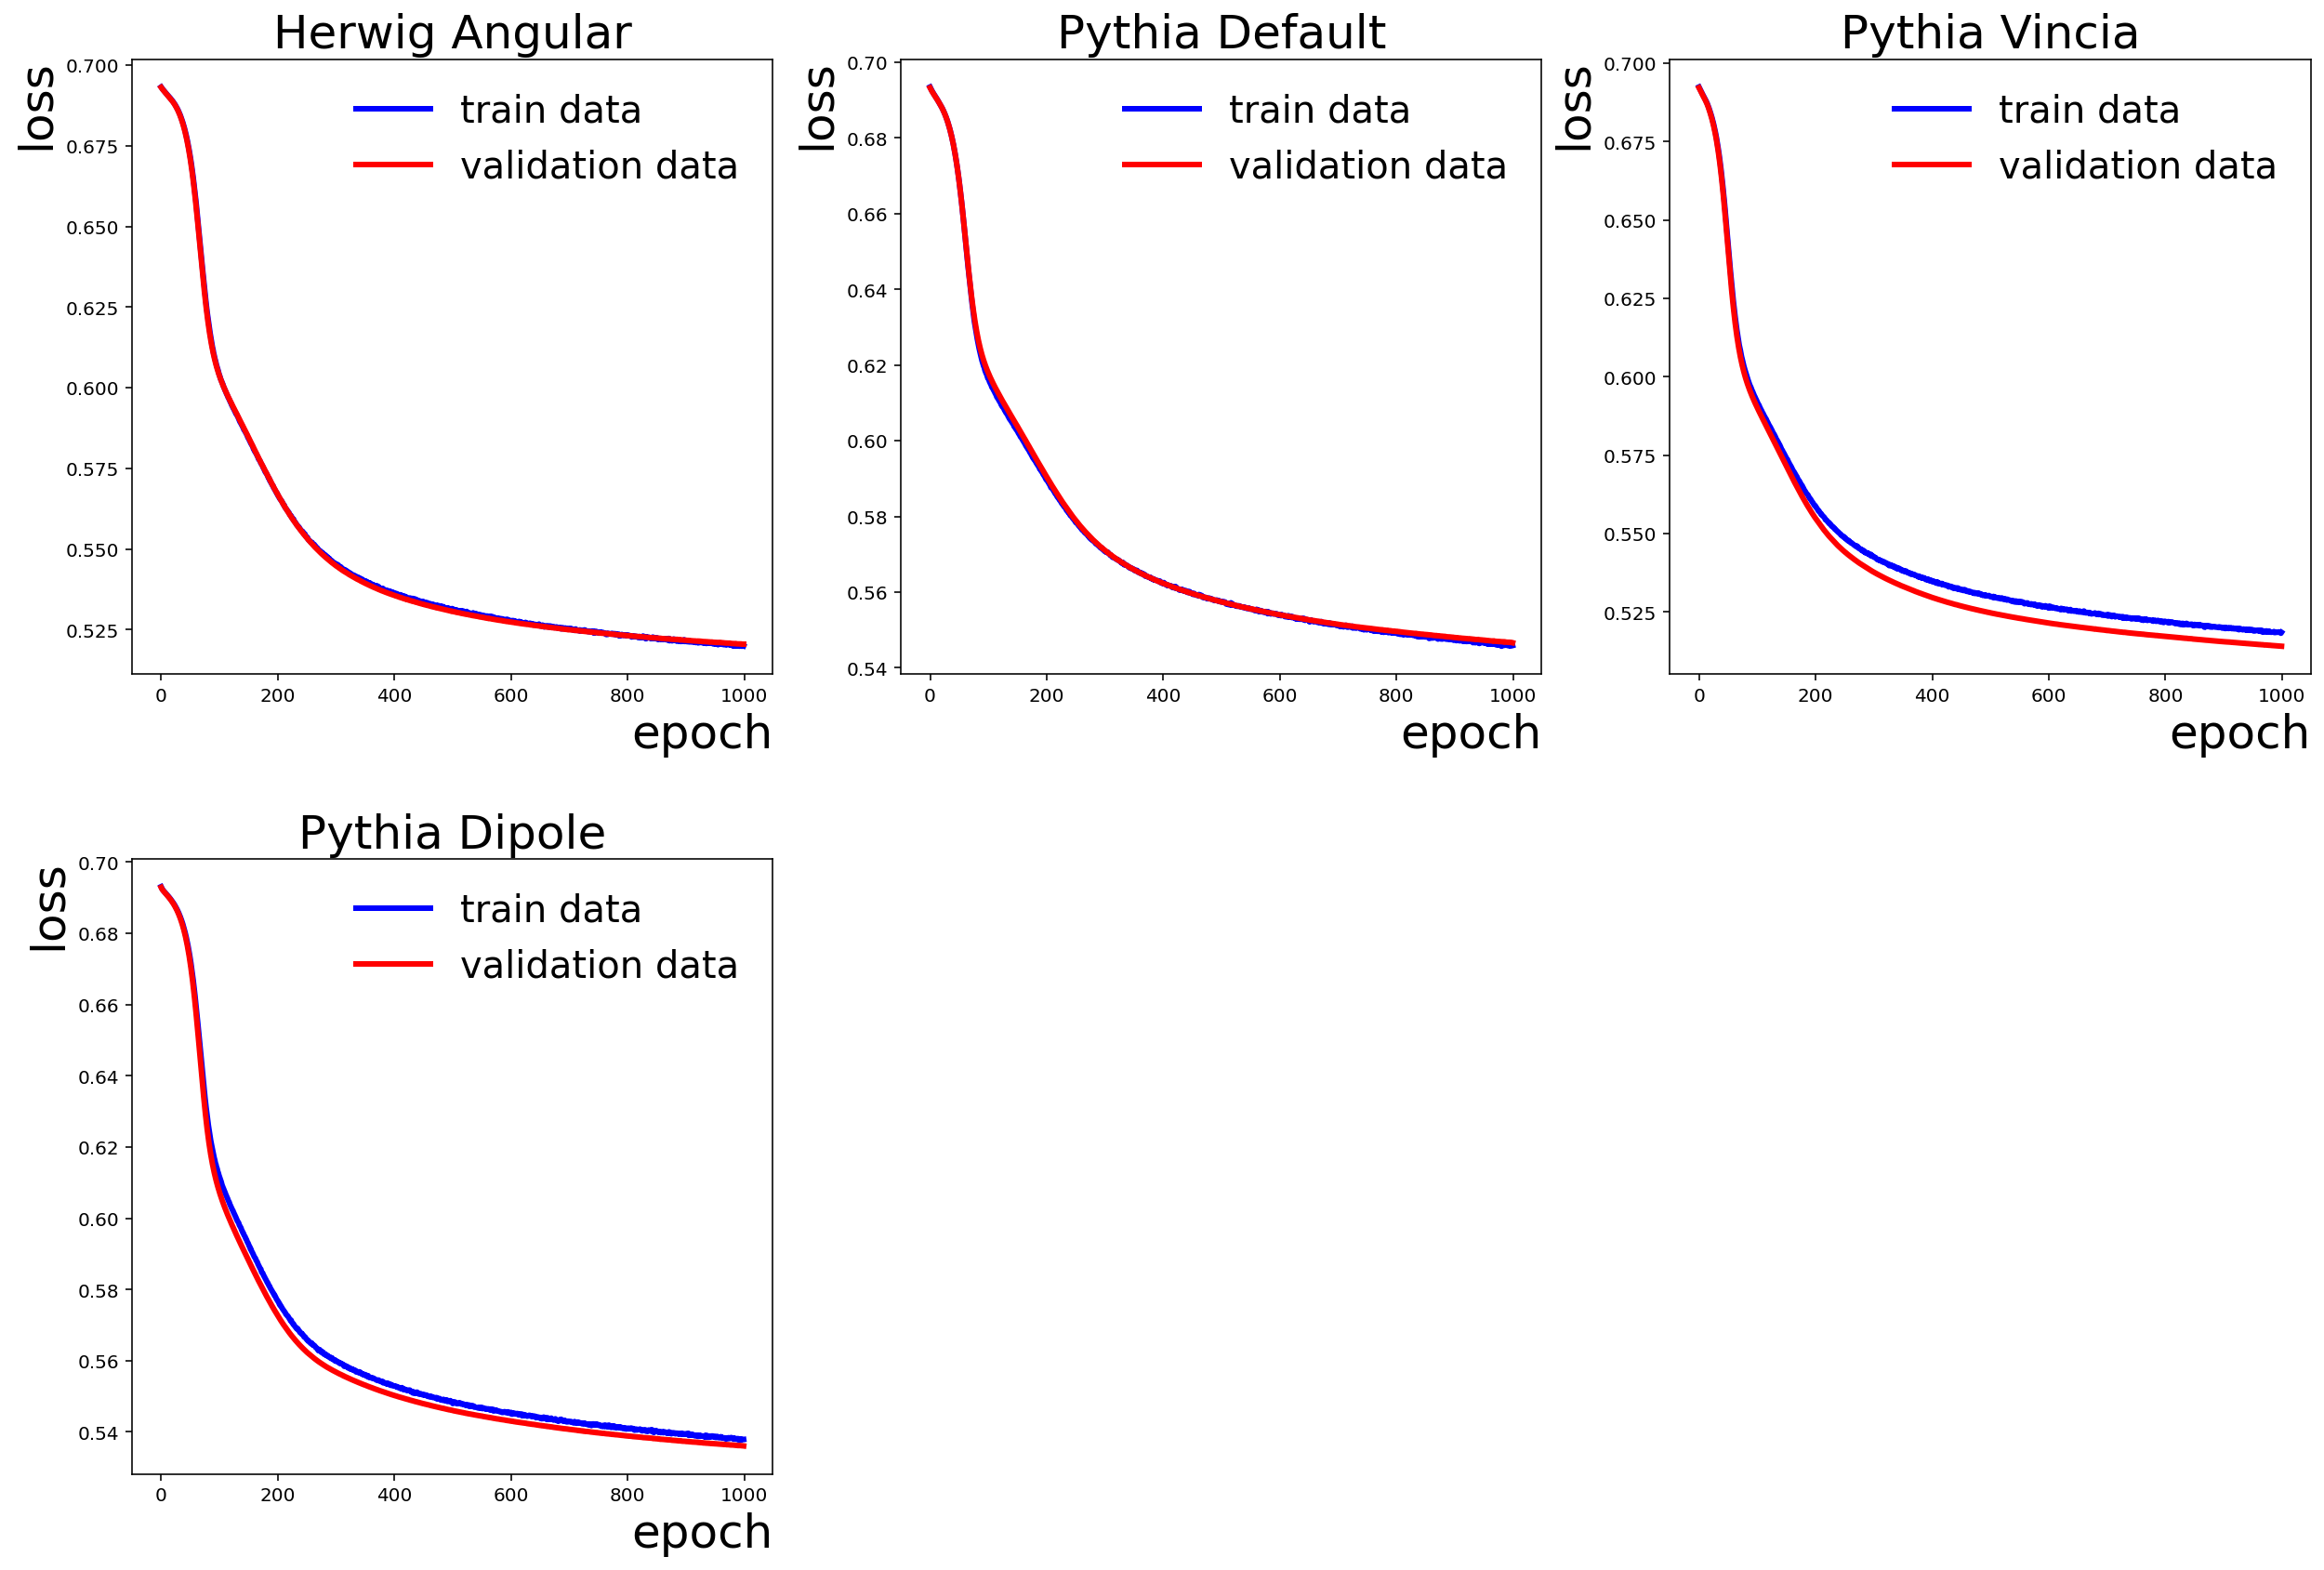

In [7]:
HOMEPATH = "/dicos_ui_home/alanchung/UniversalityCNN_DiHiggs/"
savepath = HOMEPATH + "Data_ML/"

# axis = 1
# if axis == 0:
#     process = "QCD"
# elif axis == 1:
#     process = "H Jet"


CNN_Model_A1_name = [
                 "Herwig Angular", 
                 "Pythia Default",
                 "Pythia Vincia",
                 "Pythia Dipole",  
#                  "Sherpa Default"
                ]

plt.figure(figsize=(21,14))
for i,(name, datadict) in enumerate(zip(CNN_Model_A1_name, data_dict)): 
    plot_axis = plt.subplot(2,3,i+1)
    
#     fig.subplots_adjust(bottom=0.18, left=0.18, top=0.95, right=0.95)

    history = pd.read_csv(savepath + "NN_Models/" + datadict + "_history_A1_288876.csv")
# #     for k in [100000,150000,200000,250000,300000]:
#     for k in [400000]:
#         history_tmp = pd.read_csv(savepath + "NN_Models/" + datadict + "_history_A1_" + str(k) + ".csv")
#         history = pd.concat([history, history_tmp],ignore_index=True,axis=0,join='inner')

#     plt.tick_params(which='both', width=2)
#     plt.tick_params(which='major', length=8)
#     plt.tick_params(which='minor', length=4, color='k')
    plot_axis.plot(history["loss"], label='train data',c='blue',linewidth = 3)
    plot_axis.plot(history["val_loss"], label='validation data',c='red',linewidth = 3)

    plt.title(name, fontsize=25)

    plot_axis.set_ylabel('loss', fontsize=25,horizontalalignment='right',y=1)
    plot_axis.set_xlabel('epoch', fontsize=25,horizontalalignment='right',x=1)
    plot_axis.legend(loc='best', prop={'size':20}, edgecolor = "w",fancybox=False, framealpha=0)

#     plt.tick_params(which='minor',width=0)
#     plt.tick_params(labelsize=25)
    # plt.savefig("./Figures/learning_curve_w_noise.pdf", transparent=True)
    
#     plot_axis.set_ylim((0,0.01))
#     plot_axis.set_xlim((400,500))
plt.subplots_adjust(wspace=0.2, hspace=0.3)
plt.show()

# Study the Performance of CNN Architecture 1 

In [28]:
HOMEPATH = "/dicos_ui_home/alanchung/UniversalityCNN_DiHiggs/"
JetImagePath =  HOMEPATH + "Data_ML/" +"Image_Directory_Leading/"
savepath = HOMEPATH + "Data_ML/"

# axis = 1
# if axis == 0:
#     process = "QCD"
# elif axis == 1:
#     process = "H Jet"


CNN_Model_A1_name = [
                 "Herwig Angular", 
                 "Pythia Default",
                 "Pythia Vincia", 
                 "Pythia Dipole", 
#                  "Sherpa Default"
                ]

AUC = np.zeros((5,5))
max_sig = np.zeros((5,5))
r05 = np.zeros((5,5))


for i,(testdata, datadict) in enumerate(zip(data_test, data_dict)): 
    
    logging.info("Test Data: {}".format(testdata))
    
    x_test_jet, target_test = Loading_Data(data_test[testdata], datadict, jet_type="Leading", stop=60000)
    

    
    for j, model in enumerate(CNN_Model_A1):
        
        prediction_test =  CNN_Model_A1[model].predict(x_test_jet)
        discriminator_test = prediction_test
        discriminator_test = discriminator_test/(max(discriminator_test))
        
        
        AUC[j,i] = metrics.roc_auc_score(target_test,discriminator_test)
        FalsePositiveFull, TruePositiveFull, _ = metrics.roc_curve(target_test,discriminator_test)
        tmp = np.where(FalsePositiveFull != 0)
        max_sig[j,i] = max(TruePositiveFull[tmp]/np.sqrt(FalsePositiveFull[tmp])) 
        tmp = np.where(TruePositiveFull >= 0.5)
        r05[j,i] = 1./FalsePositiveFull[tmp[0][0]]

        
logging.info("Models are trained by row and test to column.")
logging.info("\r")
logging.info("Performance in AUC")
logging.info("\r")
logging.info("{:^15}{:^15}{:^15}{:^15}{:^15}{:^15}{:^10}{:^10}".format("","Herwig Angular","Pythia Default","Pythia Vincia","Pythia Dipole","Sherpa Default", "Average", "STD"))
for i in range(len(CNN_Model_A1_name)):
    logging.info("{:^15}{:^15.3f}{:^15.3f}{:^15.3f}{:^15.3f}{:^15.3f}{:^10.3f}{:^10.3f}".format(CNN_Model_A1_name[i],AUC[i,0], AUC[i,1], AUC[i,2], AUC[i,3], AUC[i,4], np.average(AUC[i,:4]), np.std(AUC[i,:4])))
logging.info("{:^15}{:^15.3f}{:^15.3f}{:^15.3f}{:^15.3f}{:^15.3f}".format("Average",np.average(AUC[:4,0]), np.average(AUC[:4,1]), np.average(AUC[:4,2]), np.average(AUC[:4,3]), np.average(AUC[:4,4])))
logging.info("{:^15}{:^15.3f}{:^15.3f}{:^15.3f}{:^15.3f}{:^15.3f}".format("STD",np.std(AUC[:4,0]), np.std(AUC[:4,1]), np.std(AUC[:4,2]), np.std(AUC[:4,3]), np.std(AUC[:4,4])))
logging.info("\r")
logging.info("Performance in Max Significance")
logging.info("\r")
for i in range(len(CNN_Model_A1_name)):
    logging.info("{:^15}{:^15.3f}{:^15.3f}{:^15.3f}{:^15.3f}{:^15.3f}{:^10.3f}{:^10.3f}".format(CNN_Model_A1_name[i],max_sig[i,0], max_sig[i,1], max_sig[i,2], max_sig[i,3], max_sig[i,4], np.average(max_sig[i,:4]), np.std(max_sig[i,:4])))

logging.info("{:^15}{:^15.3f}{:^15.3f}{:^15.3f}{:^15.3f}{:^15.3f}".format("Average",np.average(max_sig[:4,0]), np.average(max_sig[:4,1]), np.average(max_sig[:4,2]), np.average(max_sig[:4,3]), np.average(max_sig[:4,4])))
logging.info("{:^15}{:^15.3f}{:^15.3f}{:^15.3f}{:^15.3f}{:^15.3f}".format("STD",np.std(max_sig[:4,0]), np.std(max_sig[:4,1]), np.std(max_sig[:4,2]), np.std(max_sig[:4,3]), np.std(max_sig[:4,4])))    
logging.info("\r")
logging.info("1/fpr @ tpr = 0.5 (rejection at 50% signal efficiency)")
logging.info("\r")
for i in range(len(CNN_Model_A1_name)):
    logging.info("{:^15}{:^15.3f}{:^15.3f}{:^15.3f}{:^15.3f}{:^15.3f}{:^10.3f}{:^10.3f}".format(CNN_Model_A1_name[i],r05[i,0], r05[i,1], r05[i,2], r05[i,3], r05[i,4], np.average(r05[i,:4]), np.std(r05[i,:4])))
logging.info("{:^15}{:^15.3f}{:^15.3f}{:^15.3f}{:^15.3f}{:^15.3f}".format("Average",np.average(r05[:4,0]), np.average(r05[:4,1]), np.average(r05[:4,2]), np.average(r05[:4,3]), np.average(r05[:4,4])))
logging.info("{:^15}{:^15.3f}{:^15.3f}{:^15.3f}{:^15.3f}{:^15.3f}".format("STD",np.std(r05[:4,0]), np.std(r05[:4,1]), np.std(r05[:4,2]), np.std(r05[:4,3]), np.std(r05[:4,4])))    






Test Data: herwig_ang_test


 97%|█████████▋| 60000/61902 [01:32<00:02, 650.91it/s]


Test Data: pythia_def_test


 97%|█████████▋| 60000/61902 [02:21<00:04, 423.13it/s]


Test Data: pythia_vin_test


 97%|█████████▋| 60000/61902 [08:43<00:16, 114.52it/s]


Test Data: pythia_dip_test


 97%|█████████▋| 60000/61902 [02:20<00:04, 427.78it/s]


Models are trained by row and test to column.

Performance in AUC

               Herwig Angular Pythia Default  Pythia Vincia  Pythia Dipole Sherpa Default  Average     STD    
Herwig Angular      0.818          0.783          0.798          0.818          0.000       0.804     0.015   
Pythia Default      0.806          0.793          0.801          0.813          0.000       0.803     0.007   
 Pythia Vincia      0.815          0.787          0.802          0.821          0.000       0.806     0.013   
 Pythia Dipole      0.812          0.790          0.804          0.819          0.000       0.806     0.011   
    Average         0.813          0.788          0.801          0.818          0.000     
      STD           0.004          0.004          0.002          0.003          0.000     

Performance in Max Significance

Herwig Angular      1.671          1.563          1.686          1.638          0.000       1.639     0.047   
Pythia Default      1.577          1.706          1

# AUC Performance Plots

Training Data: herwig_ang_train, Test Data: herwig_ang_test


 97%|█████████▋| 60000/61902 [01:51<00:03, 539.70it/s]
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide


Training Data: pythia_def_train, Test Data: pythia_def_test


 97%|█████████▋| 60000/61902 [01:26<00:02, 694.16it/s]
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide


Training Data: pythia_vin_train, Test Data: pythia_vin_test


 97%|█████████▋| 60000/61902 [01:26<00:02, 690.28it/s]
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide


Training Data: pythia_dip_train, Test Data: pythia_dip_test


 97%|█████████▋| 60000/61902 [01:26<00:02, 696.10it/s]
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide


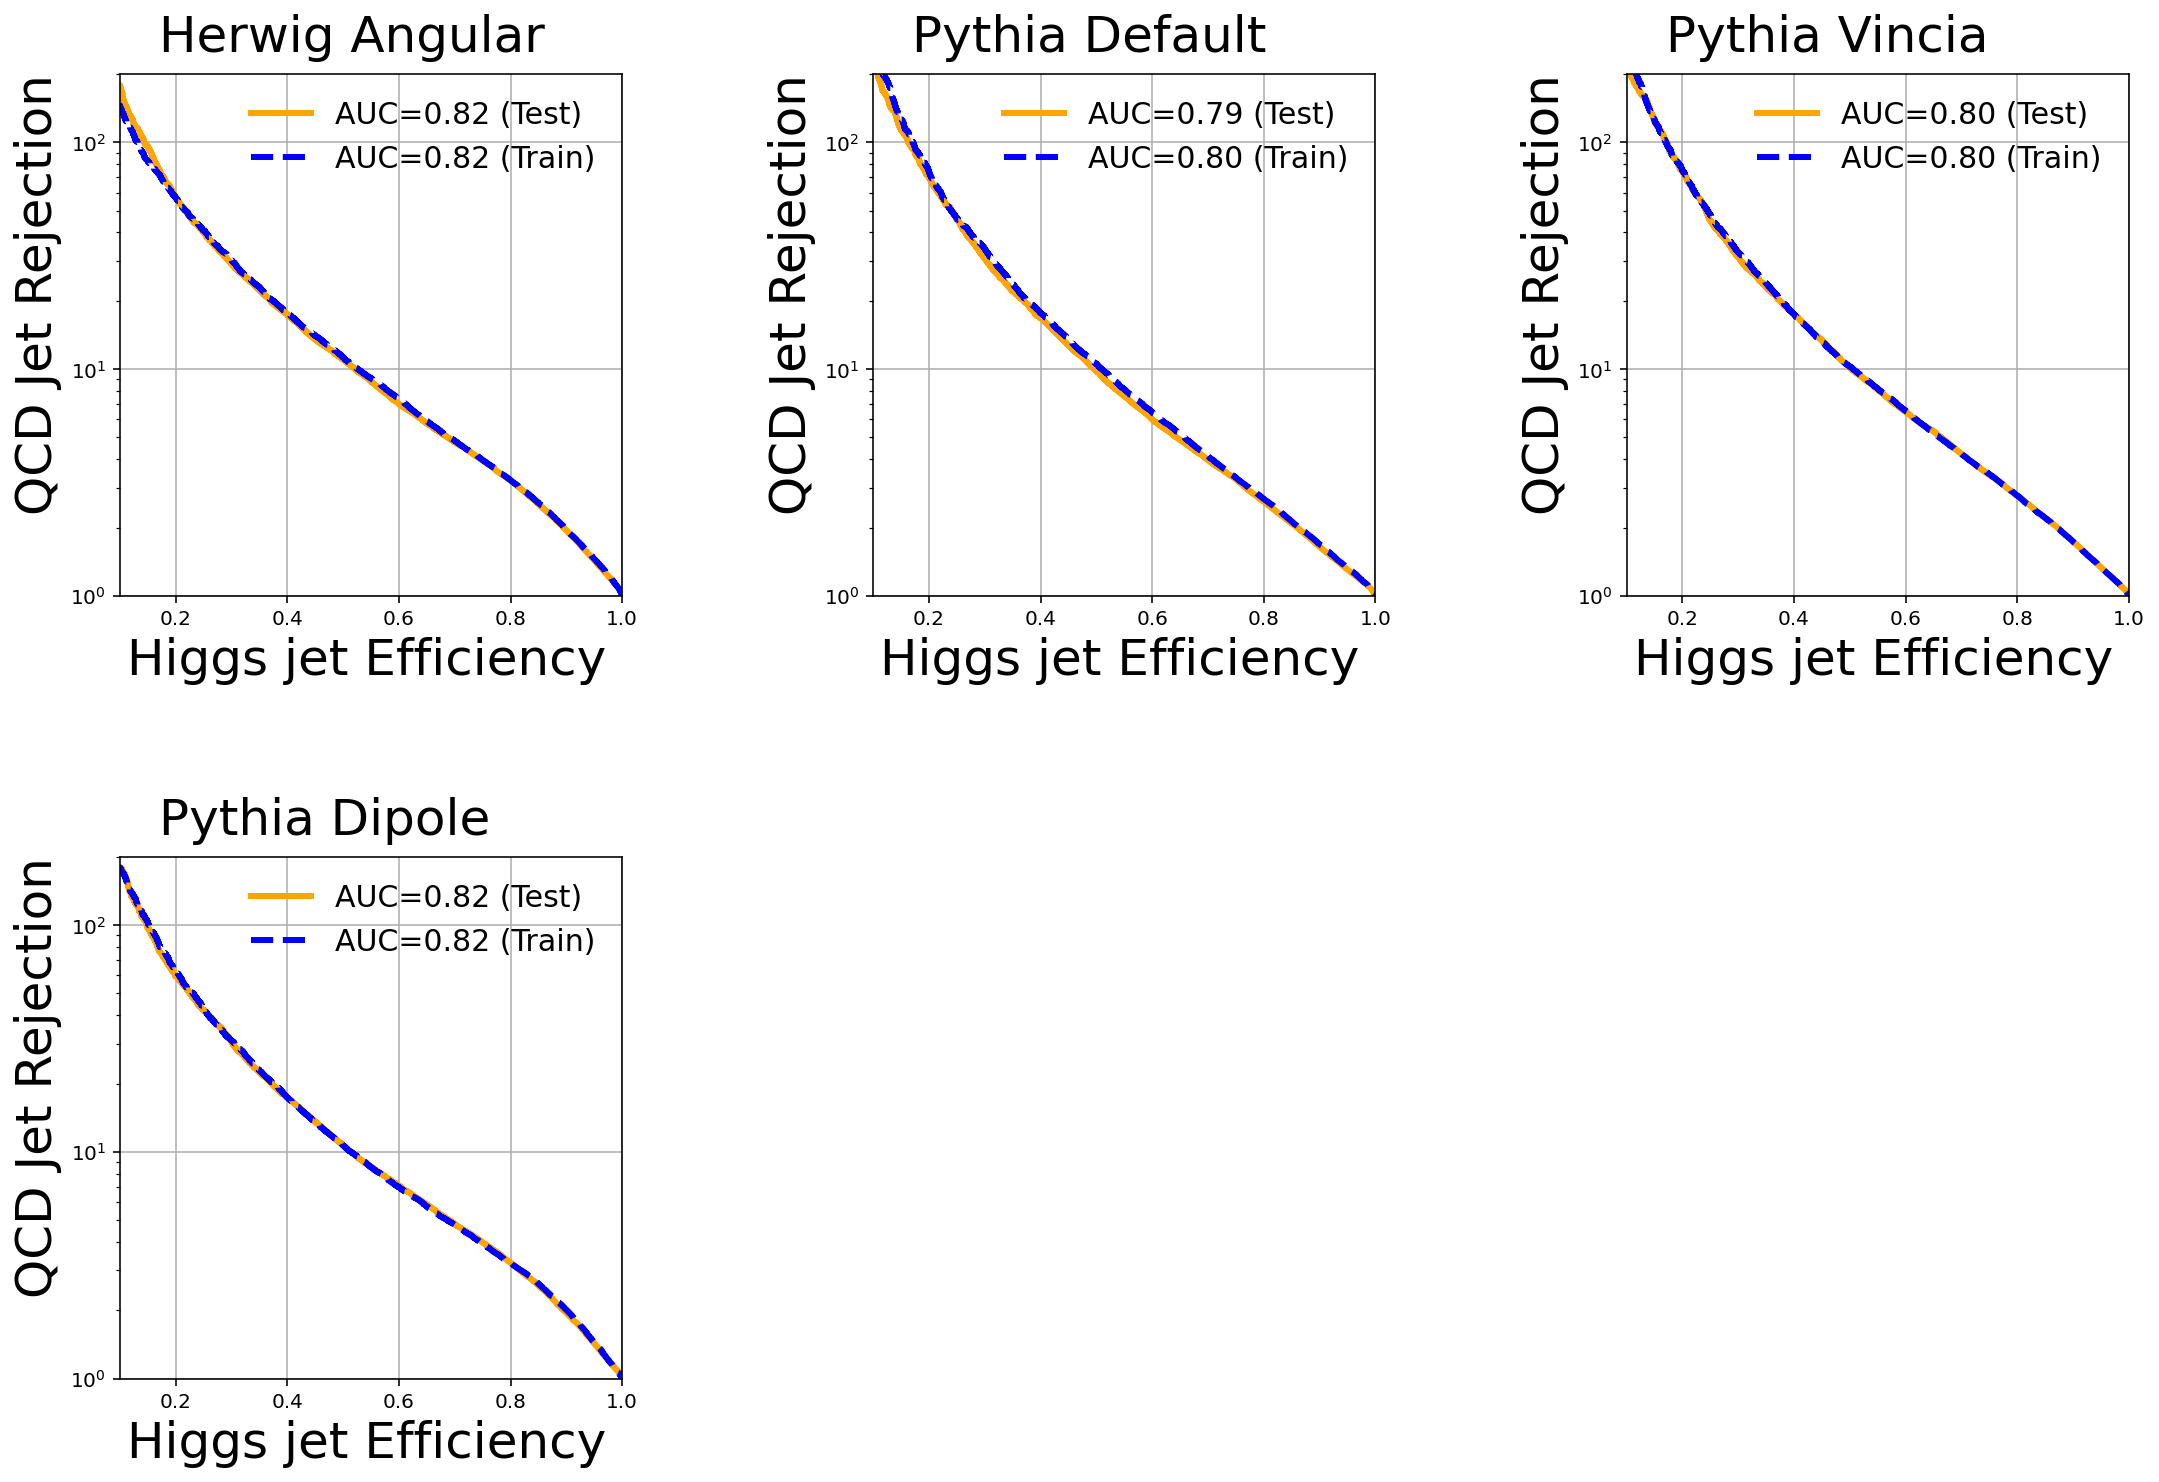

In [12]:
CNN_Model_A1_name = [
                 "Herwig Angular", 
                 "Pythia Default",
                 "Pythia Vincia", 
                 "Pythia Dipole", 
#                  "Sherpa Default"
                ]


plt.figure(figsize=(18,12))
for i,(traindata, testdata, model, datadict) in enumerate(zip(data_train, data_test, CNN_Model_A1, data_dict)): 
    
    logging.info("Training Data: {}, Test Data: {}".format(traindata, testdata))
    
    x_train_jet, target_train = Loading_Data(data_train[traindata], datadict, jet_type="Leading", stop=60000)
    
    x_test_jet, target_test = Loading_Data(data_test[testdata], datadict, jet_type="Leading", stop=60000)
    

    plot_axis = plt.subplot(2,3,i+1)

    prediction_CNN_test = CNN_Model_A1[model].predict(x_test_jet)
    prediction_CNN_train = CNN_Model_A1[model].predict(x_train_jet)

    discriminator_test = prediction_CNN_test
    discriminator_train = prediction_CNN_train

    discriminator_test = discriminator_test/(max(discriminator_test))
    discriminator_train = discriminator_train/(max(discriminator_train))
    


    test_auc_CNN_test = metrics.roc_auc_score(target_test,discriminator_test)
    FalsePositiveFull_CNN_test, TruePositiveFull_CNN_test, _ = metrics.roc_curve(target_test,discriminator_test)

    train_auc_CNN_train = metrics.roc_auc_score(target_train,discriminator_train)
    FalsePositiveFull_CNN_train, TruePositiveFull_CNN_train, _ = metrics.roc_curve(target_train,discriminator_train)


#     plt.plot(TruePositiveFull_CNN_test,1-FalsePositiveFull_CNN_test,"-", color='orange', linewidth = 3, label='AUC={0:.2f} (Test)'.format(test_auc_CNN_test))
#     plt.plot(TruePositiveFull_CNN_train,1-FalsePositiveFull_CNN_train,"--", color='b', linewidth = 3, label='AUC={0:.2f} (Train)'.format(train_auc_CNN_train))
    plt.plot(TruePositiveFull_CNN_test,1./FalsePositiveFull_CNN_test,"-", color='orange', linewidth = 3, label='AUC={0:.2f} (Test)'.format(test_auc_CNN_test))
    plt.plot(TruePositiveFull_CNN_train,1./FalsePositiveFull_CNN_train,"--", color='b', linewidth = 3, label='AUC={0:.2f} (Train)'.format(train_auc_CNN_train))



# plt.scatter(0.75,1./0.32, marker="D", s=300 , c='b')
# plt.scatter(0.70,1./0.13, marker="D", s=300 , c='orange')

#     plot_axis.set_xlim((0,1))
#     plot_axis.set_ylim((0,1))
    # plt.yscale("log")
    plt.xlim((0,1))
    plt.ylim((1, 1E+4))
    plt.yscale("log")
#     plot_axis.set_tick_params(axis='x', labelsize=25)
#     plot_axis.set_tick_params(axis='y', labelsize=25)
    # ax.yaxis.set_major_locator(MaxNLocator(5))
    # ax.xaxis.set_major_locator(MaxNLocator(5))
    plot_axis.set_xlabel('Higgs jet Efficiency ', fontsize=25,horizontalalignment='right',x=1)
    plot_axis.set_ylabel('QCD Jet Rejection', fontsize=25,horizontalalignment='right',y=1)
    plot_axis.legend(ncol=1,fontsize=15, edgecolor = "w",fancybox=False, framealpha=0) #bbox_to_anchor=(0.7, 0.1),
#     plt.tight_layout()
    plot_axis.text(x=0.17, y=2.5E+2, s=str(CNN_Model_A1_name[i]),fontsize=25) 

    plot_axis.set_xlim((0.1,1))
    plot_axis.set_ylim((1, 2E+2))
    plot_axis.set_yscale("log")
    plot_axis.grid()
# plt.savefig("./Higgs_Pt/Comparison_ROC.pdf", transparent=True)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

# Max Significance Performance Plots

Training Data: herwig_ang_train, Test Data: herwig_ang_test


 97%|█████████▋| 60000/61902 [01:24<00:02, 710.01it/s]


Training Data: pythia_def_train, Test Data: pythia_def_test


 97%|█████████▋| 60000/61902 [01:22<00:02, 724.90it/s]


Training Data: pythia_vin_train, Test Data: pythia_vin_test


 97%|█████████▋| 60000/61902 [01:23<00:02, 716.02it/s]


Training Data: pythia_dip_train, Test Data: pythia_dip_test


 97%|█████████▋| 60000/61902 [01:24<00:02, 710.27it/s]


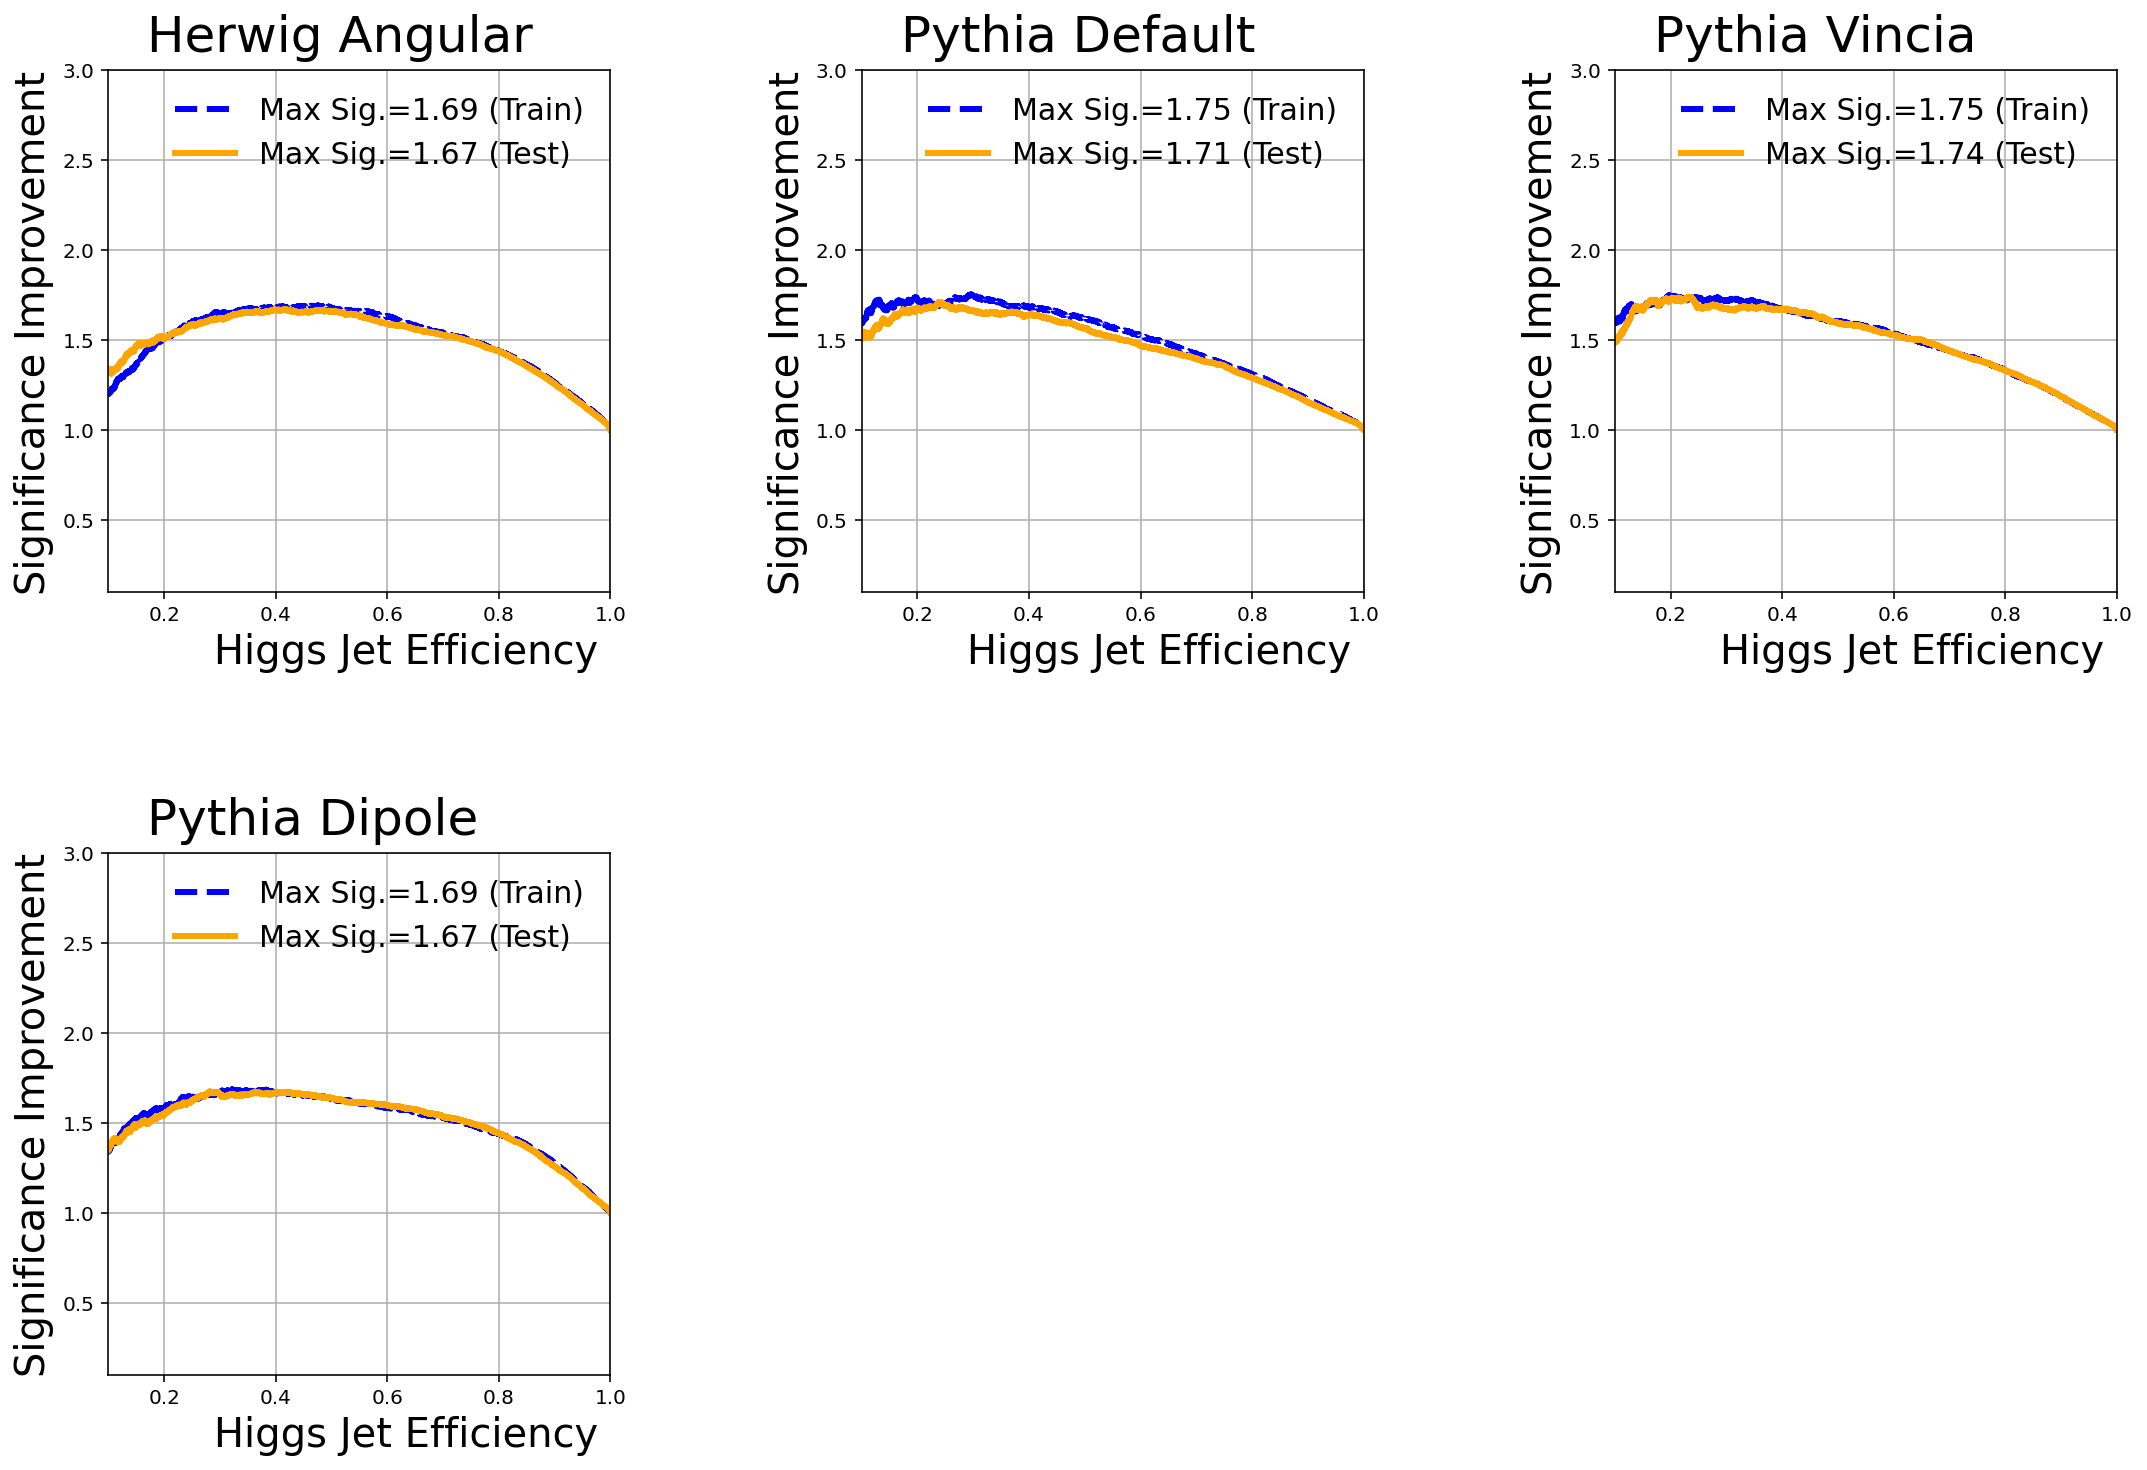

In [11]:
CNN_Model_A1_name = [
                 "Herwig Angular", 
                 "Pythia Default",
                 "Pythia Vincia", 
                 "Pythia Dipole", 
#                  "Sherpa Default"
                ]


plt.figure(figsize=(18,12))
for i,(traindata, testdata, model, datadict) in enumerate(zip(data_train, data_test, CNN_Model_A1, data_dict)): 
    
    logging.info("Training Data: {}, Test Data: {}".format(traindata, testdata))
    
    
    x_train_jet, target_train = Loading_Data(data_train[traindata], datadict, jet_type="Leading", stop=60000)
    
    x_test_jet, target_test = Loading_Data(data_test[testdata], datadict, jet_type="Leading", stop=60000)
    
    
    plot_axis = plt.subplot(2,3,i+1)


    prediction_CNN_test = CNN_Model_A1[model].predict(x_test_jet)
    prediction_CNN_train = CNN_Model_A1[model].predict(x_train_jet)

    discriminator_test = prediction_CNN_test
    discriminator_train = prediction_CNN_train

    discriminator_test = discriminator_test/(max(discriminator_test))
    discriminator_train = discriminator_train/(max(discriminator_train))
    


    test_auc_CNN_test = metrics.roc_auc_score(target_test,discriminator_test)
    FalsePositiveFull_CNN_test, TruePositiveFull_CNN_test, _ = metrics.roc_curve(target_test,discriminator_test)

    train_auc_CNN_train = metrics.roc_auc_score(target_train,discriminator_train)
    FalsePositiveFull_CNN_train, TruePositiveFull_CNN_train, _ = metrics.roc_curve(target_train,discriminator_train)
 
    a = np.where(TruePositiveFull_CNN_test > 0.1)
    b = np.where(TruePositiveFull_CNN_train > 0.1)
#     plt.plot(TruePositiveFull_CNN_test,1-FalsePositiveFull_CNN_test,"-", color='orange', linewidth = 3, label='AUC={0:.2f} (Test)'.format(test_auc_CNN_test))
    max_sig_test = max(TruePositiveFull_CNN_test[a]/np.sqrt(FalsePositiveFull_CNN_test[a]))
    max_sig_train = max(TruePositiveFull_CNN_train[b]/np.sqrt(FalsePositiveFull_CNN_train[b]))
    plt.plot(TruePositiveFull_CNN_train[b],TruePositiveFull_CNN_train[b]/np.sqrt(FalsePositiveFull_CNN_train[b]),"--", color='b', linewidth = 3, label='Max Sig.={0:.2f} (Train)'.format(max_sig_train))
    plt.plot(TruePositiveFull_CNN_test[a],TruePositiveFull_CNN_test[a]/np.sqrt(FalsePositiveFull_CNN_test[a]),"-", color='orange', linewidth = 3, label='Max Sig.={0:.2f} (Test)'.format(max_sig_test))

# plt.scatter(0.75,1./0.32, marker="D", s=300 , c='b')
# plt.scatter(0.70,1./0.13, marker="D", s=300 , c='orange')

    plot_axis.set_xlim((0.1,1))
    plot_axis.set_ylim((0.1,3))
    # plt.yscale("log")
    plt.xlim((0.1,1))
#     plt.ylim((1, 1E+4))
#     plt.yscale("log")
#     plot_axis.set_tick_params(axis='x', labelsize=25)
#     plot_axis.set_tick_params(axis='y', labelsize=25)
    # ax.yaxis.set_major_locator(MaxNLocator(5))
    # ax.xaxis.set_major_locator(MaxNLocator(5))
    plot_axis.set_xlabel('Higgs Jet Efficiency ', fontsize=20,horizontalalignment='right',x=1)
    plot_axis.set_ylabel('Significance Improvement', fontsize=20,horizontalalignment='right',y=1)
    plot_axis.legend(ncol=1,fontsize=15, edgecolor = "w",fancybox=False, framealpha=0) #bbox_to_anchor=(0.7, 0.1),
#     plt.tight_layout()
    plot_axis.text(x=0.17, y=3.1, s=str(CNN_Model_A1_name[i]),fontsize=25) 

    plot_axis.set_xlim((0.1,1))
#     plot_axis.set_ylim((1, 2E+2))
#     plot_axis.set_yscale("log")
    plot_axis.grid()
# plt.savefig("./Higgs_Pt/Comparison_ROC.pdf", transparent=True)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

In [ ]:
# axis = 1
# if axis == 0:
#     process = "QCD"
# elif axis == 1:
#     process = "W Jet"

# plt.figure(figsize=(6,6))

# CNN = load_model(savepath + CNN_Model[1] + "_CNN.h5")

# prediction_CNN_herwig_ang = CNN.predict_proba(XTEST[0])
# prediction_CNN_pythia_def = CNN.predict_proba(XTEST[1])
# prediction_CNN_pythia_vin= CNN.predict_proba(XTEST[2])
# prediction_CNN_pythia_dip = CNN.predict_proba(XTEST[3])
# prediction_CNN_sherpa_def = CNN.predict_proba(XTEST[4])


# # discriminator_test = discriminator_test/(max(discriminator_test))
# # discriminator_train = discriminator_train/(max(discriminator_train))
    


# test_auc_herwig_ang = metrics.roc_auc_score(YTEST[0],prediction_CNN_herwig_ang)
# FalsePositiveFull_herwig_ang, TruePositiveFull_herwig_ang, _ = metrics.roc_curve(YTEST[0],prediction_CNN_herwig_ang)

# test_auc_pythia_def = metrics.roc_auc_score(YTEST[1],prediction_CNN_pythia_def)
# FalsePositiveFull_pythia_def, TruePositiveFull_pythia_def, _ = metrics.roc_curve(YTEST[1],prediction_CNN_pythia_def)

# test_auc_pythia_vin = metrics.roc_auc_score(YTEST[2],prediction_CNN_pythia_vin)
# FalsePositiveFull_pythia_vin, TruePositiveFull_pythia_vin, _ = metrics.roc_curve(YTEST[2],prediction_CNN_pythia_vin)

# test_auc_pythia_dip = metrics.roc_auc_score(YTEST[3],prediction_CNN_pythia_dip)
# FalsePositiveFull_pythia_dip, TruePositiveFull_pythia_dip, _ = metrics.roc_curve(YTEST[3],prediction_CNN_pythia_dip)

# test_auc_sherpa_def = metrics.roc_auc_score(YTEST[4],prediction_CNN_sherpa_def)
# FalsePositiveFull_sherpa_def, TruePositiveFull_sherpa_def, _ = metrics.roc_curve(YTEST[4],prediction_CNN_sherpa_def)

# #     plt.plot(TruePositiveFull_CNN_test,1-FalsePositiveFull_CNN_test,"-", color='orange', linewidth = 3, label='AUC={0:.2f} (Test)'.format(test_auc_CNN_test))
# #     plt.plot(TruePositiveFull_CNN_train,1-FalsePositiveFull_CNN_train,"--", color='b', linewidth = 3, label='AUC={0:.2f} (Train)'.format(train_auc_CNN_train))
# plt.plot(TruePositiveFull_herwig_ang,1./FalsePositiveFull_herwig_ang,"-", color='orange', linewidth = 2, label='Herwig Ang. AUC={0:.2f}'.format(test_auc_herwig_ang))
# plt.plot(TruePositiveFull_pythia_def,1./FalsePositiveFull_pythia_def,"-", color='b', linewidth = 2, label='Pythia Def. AUC={0:.2f}'.format(test_auc_pythia_def))
# plt.plot(TruePositiveFull_pythia_vin,1./FalsePositiveFull_pythia_vin,"-.", color='r', linewidth = 2, label='Pythia Vin. AUC={0:.2f}'.format(test_auc_pythia_vin))
# plt.plot(TruePositiveFull_pythia_dip,1./FalsePositiveFull_pythia_dip,"-", color='g', linewidth = 2, label='Pythia Dip. AUC={0:.2f}'.format(test_auc_pythia_dip))
# plt.plot(TruePositiveFull_sherpa_def,1./FalsePositiveFull_sherpa_def,"-", color='k', linewidth = 2, label='Serpa Def. AUC={0:.2f}'.format(test_auc_sherpa_def))

# # plt.scatter(0.75,1./0.32, marker="D", s=300 , c='b')
# # plt.scatter(0.70,1./0.13, marker="D", s=300 , c='orange')


# plt.xlim((0.1,1))
# plt.ylim((1, 2E+2))
# plt.yscale("log")
# #     plot_axis.set_tick_params(axis='x', labelsize=25)
# #     plot_axis.set_tick_params(axis='y', labelsize=25)
#     # ax.yaxis.set_major_locator(MaxNLocator(5))
#     # ax.xaxis.set_major_locator(MaxNLocator(5))
# plt.xlabel(str(process)+' Efficiency ', fontsize=25,horizontalalignment='right',x=1)
# plt.ylabel('1/[QCD Jet Rejection]', fontsize=25,horizontalalignment='right',y=1)
# plt.legend(ncol=1,fontsize=15, edgecolor = "w",fancybox=False, framealpha=0) #bbox_to_anchor=(0.7, 0.1),
# #     plt.tight_layout()
# # plt.text(x=0.17, y=1.03, s=str(CNN_model_name[i]),fontsize=25) 
# plt.grid()
# # plt.savefig("./Higgs_Pt/Comparison_ROC.pdf", transparent=True)
# # plt.subplots_adjust(wspace=0.5, hspace=0.5)
# plt.show()

In [ ]:
# # History = pd.read_csv(savepath + "NN_Models/CNN_History.csv")

# """
# Plot Learning Curve
# """
# # logging.info(History.history.keys())


# fig, ax = plt.subplots(1,1, figsize=(10,10))

# plt.plot(History.history["loss"], label='training data',c='blue',linewidth = 3)
# plt.plot(History.history["val_loss"], label='validation data',c='red',linewidth = 3)

# # plt.plot(History["loss"], label='training data',c='blue',linewidth = 3)
# # plt.plot(History["val_loss"], label='validation data',c='red',linewidth = 3)

# plt.title("CNN ", fontsize=25)

# ax.set_ylabel('loss', fontsize=25,horizontalalignment='right',y=1)
# ax.set_xlabel('epoch', fontsize=25,horizontalalignment='right',x=1)
# plt.legend(loc='best', prop={'size':20}, edgecolor = "w",fancybox=False, framealpha=0)

# plt.show()


In [44]:
# Model = load_model(savepath + "NN_Models/model_CNN_2.h5")
# # Model = load_model(savepath + "NN_Models/model_CNN.h5")

# prediction_jet = Model.predict(np.array(x_test_j1))
# # target_test = to_categorical(np.array(target_test))

# axis = 1
# if axis == 1:
#     Class = "H jets"
#     other = "QCD jets"
# elif axis == 0:
#     Class = "QCD jets"
#     other = "H jets"
    
# # auc_test = metrics.roc_auc_score(target_test[:,axis],prediction_jet[:,axis])

# # FalsePositive_test, TruePositive_test, _ = metrics.roc_curve(target_test[:,axis],prediction_jet[:,axis])
# # logging.info(auc_test)

# auc_test = metrics.roc_auc_score(target_test,prediction_jet)

# FalsePositive_test, TruePositive_test, _ = metrics.roc_curve(target_test,prediction_jet)
# logging.info(auc_test)


# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))


# axes[0].plot(FalsePositive_test, TruePositive_test,linewidth = 3, linestyle="-", label='AUC={0:.2f} (Test)'.format(auc_test))

# axes[0].tick_params(axis='x', labelsize=20)
# axes[0].tick_params(axis='y', labelsize=20)
# axes[0].set_ylabel("TPR",fontsize=20)
# axes[0].set_xlabel("FPR",fontsize=20)
# axes[0].legend(ncol=1,fontsize=15) #bbox_to_anchor=(0.7, 0.1),


# # confusion = confusion_matrix(np.argmax(target_test,axis=1), np.argmax(prediction_jet,axis=1))
# confusion = confusion_matrix(target_test, np.where(prediction_jet > 0.5, 1, 0))


# truelist = ["H jet","QCD"]
# likelist = ["H-like","QCD-like"]

# s = len(truelist)
# # f, ax = plt.subplots(1,1, figsize=(s+8, s+8))

# aa = axes[1].imshow(confusion.T, cmap="Oranges", origin= "upper", vmin=0, vmax=5000)

# divider = make_axes_locatable(axes[1])
# cax = divider.append_axes("right", size="5%", pad="1%")
# cbar = plt.colorbar(aa, cax=cax)
# cbar.ax.tick_params(labelsize=20)
# # cbar.ax.yaxis.set_major_locator(MaxNLocator(6))
# cbar.set_label("Number", rotation=270, fontsize=25, labelpad=30, y=0.5)
# cbar.set_ticks([0,1250,2500,3750,5000])
# cbar.ax.set_yticklabels(["0","1250","2500","3750","5000"])

# axes[1].set_xticks(range((confusion.T).shape[1]))
# axes[1].set_xticklabels(truelist, fontsize=30, rotation=0)
# axes[1].set_yticks(range((confusion.T).shape[1]))
# axes[1].set_yticklabels(likelist, fontsize=30, rotation=45)

# my_colors = ["green","red"]
# axes[1].xaxis.tick_top()
# for ticklabel, tickcolor in zip(axes[1].get_xticklabels(), my_colors):
#     ticklabel.set_color(tickcolor)
    
# for ticklabel, tickcolor in zip(axes[1].get_yticklabels(), my_colors):
#     ticklabel.set_color(tickcolor)

# Terminology = np.array([["TP","FP"],["FN","TN"]])
    
# for (i, j), z in np.ndenumerate(confusion.T):
#     axes[1].text(j, i, '{:^3s}: {:0.0f}'.format(Terminology[i,j],z), ha='center', va='center',fontsize=25,color="white")


# plt.tight_layout()
# plt.show()